Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [350]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [4]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [313]:
train, val = train_test_split(train, train_size=0.85, test_size=0.15, stratify=train['status_group'], random_state=42)

In [314]:
train.shape, val.shape

((50490, 41), (8910, 41))

In [315]:
train['status_group'].value_counts(normalize=True)

functional                 0.543078
non functional             0.384235
functional needs repair    0.072688
Name: status_group, dtype: float64

In [8]:
train[['latitude', 'longitude']].describe()

,latitude,longitude
count,4.752000e+04,47520.000000
mean,-5.705946e+00,34.082431
std,2.941332e+00,6.552053
min,-1.164944e+01,0.000000
25%,-8.528215e+00,33.092142
50%,-5.021436e+00,34.910740
75%,-3.327185e+00,37.170578
max,-2.000000e-08,40.344301


In [9]:
train[['date_recorded', 'construction_year']].dtypes

date_recorded        object
construction_year     int64
dtype: object

In [346]:
import numpy as np

def clean_up(X):

  # make  copy of df
  X = X.copy()

  # clean up near zeros values for latitude
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # set up zero values for nan
  cols_with_zeros = ['latitude', 'longitude', 'construction_year', 'population', 'gps_height']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)


  # reduce cardinality for 'lga', 'installer', 'funder'   
  top20_col = ['lga', 'installer', 'funder']
  for col in top20_col:
    top20 = X[col].value_counts()[:20].index
    X.loc[~X[col].isin(top20), col] = 'other'
    
  # Create new feature 'year_recorded' and 'month_recorded'
  # create new feature 'num_of_years_between_constr_and_inspect' number of years from waterpump construction to waterpump inspection
  X['year_recorded'] = pd.to_datetime(X['date_recorded']).dt.year
  X['month_recorded'] = pd.to_datetime(X['date_recorded']).dt.month
  X['num_of_years_between_constr_and_inspect'] = X['year_recorded'] - X['construction_year']

  # drop duplicate and unused columns
  X = X.drop(columns=['quantity_group', 'payment_type','id', 'recorded_by', 'amount_tsh', 'num_private', 'scheme_name'])

  return X


In [347]:
train_copy = train.copy()
val_copy = val.copy()
test_copy = test.copy()

In [348]:
train_copy = clean_up(train_copy)
val_copy = clean_up(val_copy)
test_copy = clean_up(test_copy)

In [349]:
# define target
target = 'status_group'

# define features

features = train_copy.drop(columns=[target])
numeric_features = features.select_dtypes(include='number').columns.tolist()

cardinality = features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 60].index.tolist()

features = numeric_features + categorical_features
features

['gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded',
 'month_recorded',
 'num_of_years_between_constr_and_inspect',
 'funder',
 'installer',
 'basin',
 'region',
 'lga',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [338]:
X_train = train_copy[features]
y_train = train_copy[target]
X_val = val_copy[features]
y_val = val_copy[target]
X_test = test_copy[features]

In [341]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [360]:
dt = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42, max_depth=21, min_samples_leaf=5)
)

dt.fit(X_train, y_train)
print('DecisionTree train Accuracy Score ', dt.score(X_train, y_train))
print('DecisionTree validation Accuracy Score ', dt.score(X_val, y_val))

DecisionTree train Accuracy Score  0.8467419290948702
DecisionTree validation Accuracy Score  0.7841750841750842


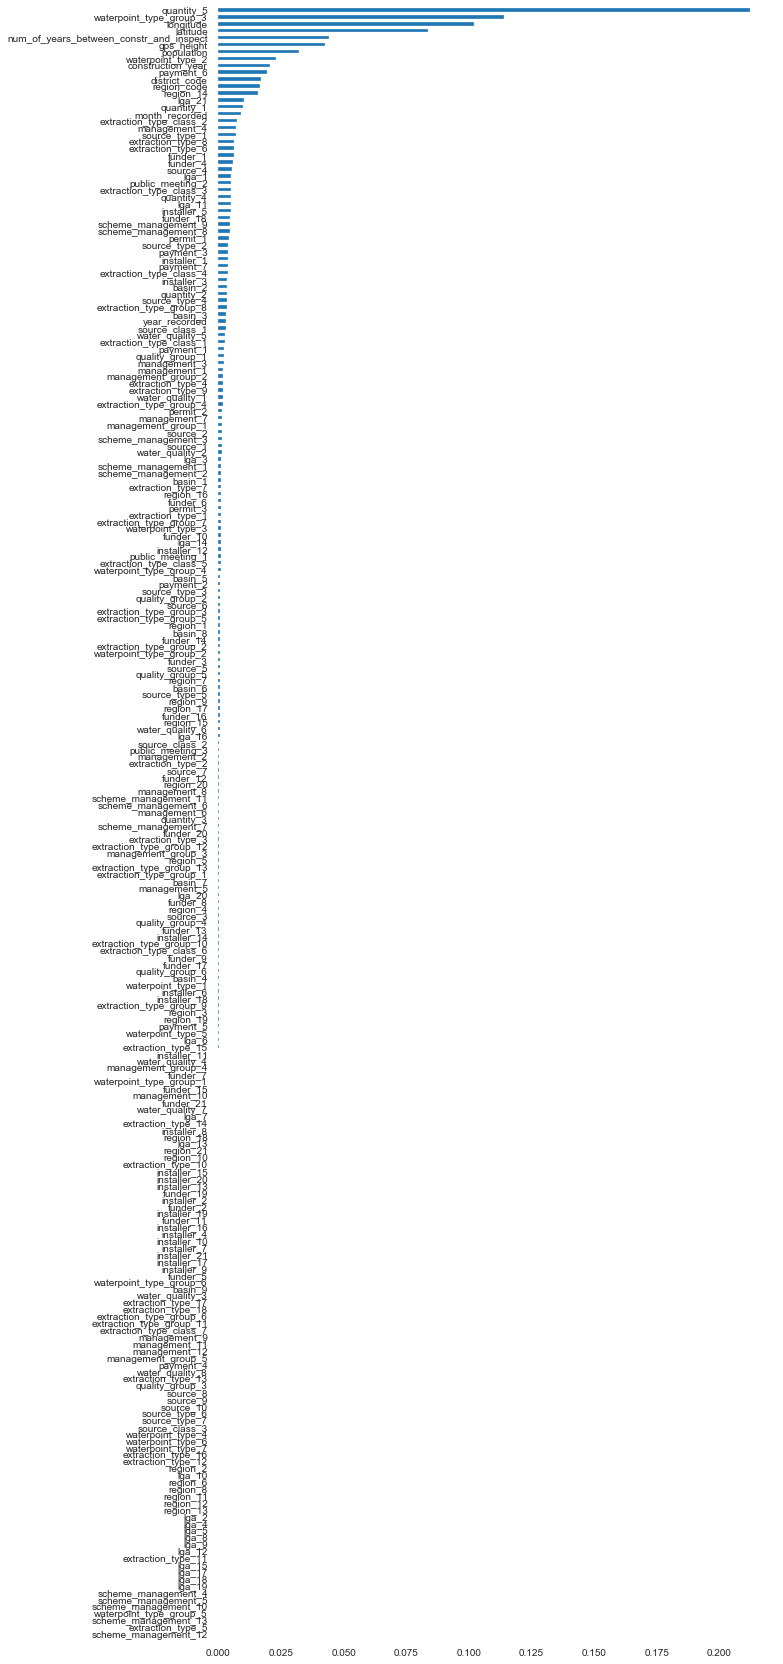

In [325]:
import matplotlib.pyplot as plt

d_tree_model = dt.named_steps['decisiontreeclassifier']
encoder = dt.named_steps['onehotencoder']
enc_columns = encoder.transform(X_val).columns
coefficients = pd.Series(d_tree_model.feature_importances_, enc_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh();

In [331]:
predictions = dt.predict(X_test)

output = pd.DataFrame({'id': test.id, 'status_group': predictions})
output
output.to_csv('my_submission.csv', index=False)

In [332]:
output

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional
